zss2024 for 23MSDS-NLP course

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

!pip install contractions -q
import contractions

!pip install textacy -q
from textacy import preprocessing

import re
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jamshaid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jamshaid\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jamshaid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jamshaid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Settings

In [10]:
fileIn = r"D:\Ai course\NAVTTAC Code\Text Classification\text_classification_toy_dataset.xlsx"

## Read dataset

In [11]:
df = pd.read_excel( fileIn, index_col=None )

text_all = df["text"].to_list()
labels = df["label"].to_numpy()

print( len(text_all), labels.shape, np.unique(labels), sum(labels==0), sum(labels==1) )

1000 (1000,) [0 1] 500 500


## Preprocessing

In [12]:
# Define function for punctuation removal
def f_punctuation_removal(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

# Define function for whitespace normalization
def f_whitespace_normalization(text):
  text = re.sub('[\s]+', ' ', text).strip()
  return text

# Remove contractions
text_all = [contractions.fix( text_current, slang=False) for text_current in text_all]

# Other steps... (feel free to add/remove as per your informed choice)
text_data = []

for text_curr in text_all:

  # - Tokenize
  tokens = word_tokenize(text_curr)

  # - Lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]

  # - Remove stopwords
  filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]

  # - Convert from tokens to sentence, lower case, punctuation removal,and append to list
  sent = " ".join( filtered_tokens ).lower()
  sent = f_punctuation_removal( sent )

  # - Remove hashtags, user handles, emojis, urls, quotation marks, brackets, numbers
  sent = preprocessing.replace.hashtags( sent, repl=" ")
  sent = preprocessing.replace.user_handles( sent, repl=" ")
  sent = preprocessing.replace.emojis( sent, repl=" ")
  sent = preprocessing.replace.urls( sent, repl=" ")

  sent = preprocessing.normalize.quotation_marks( sent )
  sent = preprocessing.remove.html_tags( sent )
  sent = preprocessing.remove.brackets( sent )
  sent = re.sub('"', '', sent)
  sent = re.sub("'", '', sent)
  sent = preprocessing.replace.numbers( sent, repl=" " )

  # - Normalize whitespace
  sent = f_whitespace_normalization( sent )

  # - Append to list
  text_data.append( sent )



## Text Classification pipeline

In [13]:
# Split the dataset into training and testing subsets (80% train, 20% test)
text_Train, text_Test, Labs_Train, Labs_Test = train_test_split( text_data, labels, test_size=0.2, stratify=labels, random_state=0)

print( len(text_Train), sum(Labs_Train)/len(Labs_Train), len(text_Test), sum(Labs_Test)/len(Labs_Test) )

800 0.5 200 0.5


In [29]:
# Set custom hyperparameters for CountVectorizer
vectorizer = CountVectorizer( ngram_range=(1, 1),  # Consider unigrams and bigrams
                              max_features=10000  # Limit the number of features to 5000
                              )

In [30]:
# Apply CountVectorizer with custom hyperparameters to transform the text data into numerical features
Feats_Train_countvec = vectorizer.fit_transform( text_Train ).toarray()
Feats_Test_countvec = vectorizer.transform( text_Test ).toarray()

print( Feats_Train_countvec.shape, Feats_Test_countvec.shape )

(800, 5039) (200, 5039)


In [31]:
print( np.mean(Feats_Train_countvec[:,0]), np.std(Feats_Train_countvec[:,0]) )

0.00125 0.035333235062756436


In [32]:
# Apply standard scaling
scaler = StandardScaler()
Feats_Train_countvec = scaler.fit_transform( Feats_Train_countvec )
Feats_Test_countvec = scaler.transform( Feats_Test_countvec )

print( Feats_Train_countvec.shape, Feats_Test_countvec.shape )

(800, 5039) (200, 5039)


In [33]:
print( np.mean(Feats_Train_countvec[:,0]), np.std(Feats_Train_countvec[:,0]) )

1.5543122344752193e-17 0.9999999999999986


c:\Users\Jamshaid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Jamshaid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.75      0.81       100
           1       0.78      0.90      0.84       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



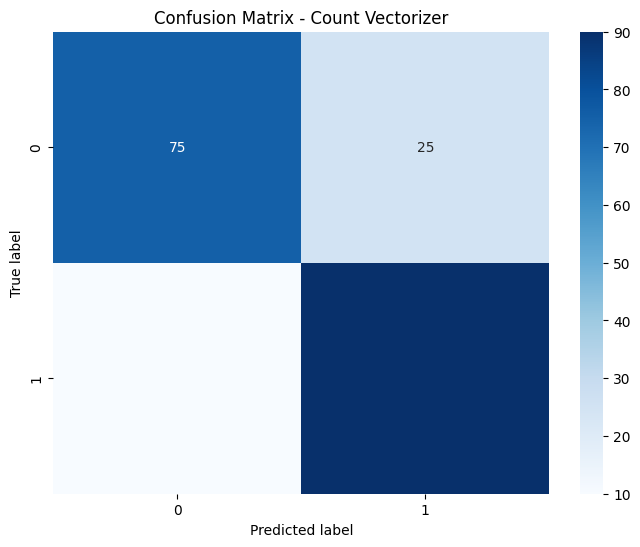

In [34]:
# Train an SVM classifier with the 'linear' kernel
clf = LinearSVC( class_weight="balanced", max_iter=1000, random_state=0)
clf.fit( Feats_Train_countvec, Labs_Train)

# Predict the classes of the testing data
predLabs_Test = clf.predict( Feats_Test_countvec )

# Evaluate the performance of the model using classification metrics
print(classification_report( Labs_Test, predLabs_Test ))

# Calculate the confusion matrix
cm = confusion_matrix( Labs_Test, predLabs_Test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Count Vectorizer')
plt.show()
